In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder,OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.linear_model import Lasso, LogisticRegression, LinearRegression
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, silhouette_score, recall_score, precision_score, make_scorer,roc_auc_score, f1_score, precision_recall_curve, f1_score,r2_score,plot_confusion_matrix,precision_recall_fscore_support
from sklearn import svm
from sklearn.utils import resample
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.inspection import PartialDependenceDisplay
import shap 
import category_encoders as ce
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import scikitplot as skplt

from multiprocessing import Process,Pool
import copy
import time
import os
import threading
from pathlib import Path
from joblib import dump, load
import re
import warnings

### Carga de datos



In [3]:
target = 'C_SEV'
numeric_features = ['C_VEHS', 'V_AGE','P_AGE','C_PERS']
categorical_features = ['C_MNTH','C_WDAY','C_HOUR','C_CONF','C_RCFG','C_WTHR','C_RSUR','C_RALN','C_TRAF','P_SEX','P_SAFE','V_TYPE']
file = 'crash_transformed_c_sev.csv'
one_hot_categories = ['C_MNTH', 'C_WDAY', 'C_HOUR', 'P_SEX']
target_categories = ['C_CONF', 'C_RCFG', 'C_WTHR','C_RSUR','C_RALN','C_TRAF','V_TYPE','P_SAFE']


dtypes = {}
for feature in numeric_features:
    dtypes[feature] = 'float' 
for feature in categorical_features:
    dtypes[feature] = 'str' 


data = pd.read_csv(f'./data/{file}',dtype=dtypes)

In [4]:
data.dtypes.to_dict()

{'C_MNTH': dtype('O'),
 'C_WDAY': dtype('O'),
 'C_HOUR': dtype('O'),
 'C_SEV': dtype('int64'),
 'C_VEHS': dtype('float64'),
 'C_CONF': dtype('O'),
 'C_RCFG': dtype('O'),
 'C_WTHR': dtype('O'),
 'C_RSUR': dtype('O'),
 'C_RALN': dtype('O'),
 'C_TRAF': dtype('O'),
 'V_TYPE': dtype('O'),
 'P_SEX': dtype('O'),
 'P_AGE': dtype('float64'),
 'P_SAFE': dtype('O'),
 'C_PERS': dtype('float64'),
 'V_AGE': dtype('float64')}

In [5]:
X = data.drop(target,axis=1)
y = data[target]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [7]:
print(f'Registros Sin muertes {len(y_train[y_train==0])}')
print(f'Registros Con muertes {len(y_train[y_train==1])}')

Registros Sin muertes 3051543
Registros Con muertes 45473


##### Subsample

El target esta desbalanceado ya que tiene la cantidad de registros sin muertes es mucho mayor y esto afecta a la precision de la prediccion sobre los casos en donde si hay muertes. Por lo que se hara un subsample para que las dos labels del target tengan la misma cantidad de registros.

In [8]:
def subsample_data(X,y):
    y_2 = resample(y[y==0], replace = True, n_samples = len(y[y==1]), random_state = 12345)
    y_resampled = pd.concat([y[y==1],y_2])
    data_resampled = X.join(y_resampled)
    data_resampled = data_resampled.dropna(subset=[y.name])
    _y = data_resampled[y.name].astype('int8')
    _x = data_resampled.drop(target,axis=1)
    return _x,_y

X_train,y_train = subsample_data(X_train,y_train)
X_train.shape

(90946, 16)

### Evaluacion de modelos

In [9]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])


categorical_transformer_one_hot = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))])

categorical_transformer_target = Pipeline(steps=[
    #('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', ce.CatBoostEncoder())])

In [10]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat1', categorical_transformer_one_hot, one_hot_categories),
        ('cat2', categorical_transformer_target, target_categories)])

In [15]:
classifiers = [LogisticRegression(n_jobs=-1),
               RandomForestClassifier(n_jobs=-1),
               XGBClassifier(n_jobs=-1),
               LGBMClassifier()]

In [20]:
pipelines = []
        
for classifier in classifiers:
    pipelines.append(make_pipeline(preprocessor,classifier,memory='./cache'))


def fit_pipeline(pipe,xtrain,xtest,ytrain,ytest,overwrite_saved_models=False):
    model_folder = './saved_models/'
    file_name = re.sub('[^a-zA-Z0-9 \n\.]', '', list(pipe.named_steps.keys())[-1])
    print(file_name)
    if not os.path.exists(model_folder):
        os.makedirs(model_folder)
    if not Path(model_folder+file_name+'.joblib').is_file() or overwrite_saved_models:
        start_time = time.time()
        logs = 'Model '+file_name+'\n'
        print('Training started')
        pipe.fit(xtrain, ytrain)
        predictions = pipe.predict(xtest)
        execution_time = (time.time() - start_time)
        logs = logs + f'train duration {execution_time} \n'
        _confusion_matrix = confusion_matrix(ytest, predictions,normalize='true')
        logs = logs + f'Confusion matrix \n {_confusion_matrix} \n'
        f1score = f1_score(ytest, predictions)
        logs = logs + f'f1 score:  {f1score}\n '
        print(logs)
        with open('./logs'+file_name+'.txt', 'w') as f:
            f.write(logs)
        dump(pipe, model_folder+file_name+'.joblib')
    print('Model trained')


#### Configurando la variable parallel en True se puede entrenar todos los modelos a la vez, sino se entrenan de forma secuencial

In [21]:
parallel = False

In [22]:
if parallel:
    import multiprocessing
    from workers import _fit_pipeline
    print('Parallel')
    params = [(pipe,X_train, X_test, y_train, y_test) for pipe in pipelines]
    #%%
    if __name__ ==  '__main__': 
        pool = multiprocessing.Pool()
        pool.starmap(_fit_pipeline, params)
        pool.close()
        pool.join()
else:
    print("Secuential")
    for pipe in pipelines:
        fit_pipeline(pipe,X_train, X_test, y_train, y_test,True)


Secuential
logisticregression
Training started
Model logisticregression
train duration 11.71224069595337 
Confusion matrix 
 [[0.78136954 0.21863046]
 [0.30279232 0.69720768]] 
f1 score:  0.0858124798625282
 
Model trained
randomforestclassifier
Training started
Model randomforestclassifier
train duration 7.158640623092651 
Confusion matrix 
 [[0.78972698 0.21027302]
 [0.27643979 0.72356021]] 
f1 score:  0.09205815250878448
 
Model trained
xgbclassifier
Training started


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[20:00:25] WARNING: D:\bld\xgboost-split_1643227225381\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model xgbclassifier
train duration 8.419881582260132 
Confusion matrix 
 [[0.79481354 0.20518646]
 [0.27408377 0.72591623]] 
f1 score:  0.09437643935698321
 
Model trained
lgbmclassifier
Training started
Model lgbmclassifier
train duration 4.977113246917725 
Confusion matrix 
 [[0.78464173 0.21535827]
 [0.26431065 0.73568935]] 
f1 score:  0.09155919963076588
 
Model trained


### Seleccion de modelo

Se tomara el Random forest classifier ya que fue el que mejores resultados obtuvo

In [25]:
param_grid = {
    'classifier__min_child_weight': [1, 5, 10],
    'classifier__gamma': [0.5, 1, 1.5, 2, 5],
    'classifier__subsample': [0.6, 0.8, 1.0],
    'classifier__colsample_bytree': [0.6, 0.8, 1.0],
    'classifier__max_depth': [3, 5, 7],
    'classifier__n_estimators':[100,20,300]
}

#seleccionar el modelo para el crossvalidation
modelname = 'xgbclassifier'

clf = load(f'./saved_models/{modelname}.joblib') 
#renombrar el classifier dentro de la pipeline
clf.steps.append(('classifier',clf.steps.pop(-1)[1]))

cf_file = './saved_models/cv.joblib'

if not Path(cf_file).is_file():
    CV = RandomizedSearchCV(clf, param_grid, n_jobs=-1)
    start_time = time.time()
    CV.fit(X_train, y_train)  
    print(f'training duration{(time.time() - start_time)} s')
    dump(CV, cf_file)
else:
    CV = load(cf_file)

print(CV.best_params_)    
print(CV.best_score_)


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[06:57:52] WARNING: D:\bld\xgboost-split_1643227225381\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
training duration100.87797045707703 s
{'classifier__subsample': 0.6, 'classifier__n_estimators': 100, 'classifier__min_child_weight': 5, 'classifier__max_depth': 3, 'classifier__gamma': 1, 'classifier__colsample_bytree': 0.6}
0.7530731866135526


In [26]:
predictions = CV.predict(X_test)
prob_predictions = CV.predict_proba(X_test)

In [57]:
model_metrics = precision_recall_fscore_support(y_test, predictions)
print(f'Precission: {model_metrics[0][0]}')
print(f'Recall: {model_metrics[1][0]}')
print(f'F1: {model_metrics[2][0]}')

Precission: 0.9948520119720652
Recall: 0.7843585555208877
F1: 0.8771538358913761


#### Matriz de confusion

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


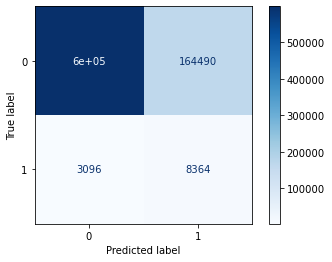

In [31]:
plot_confusion_matrix(CV, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=None)

#### Matriz de confusion normalizada

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


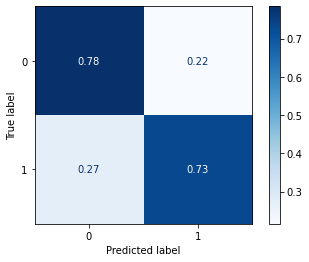

In [32]:
plot_confusion_matrix(CV, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true')

#### Curva ROC

Best Threshold=0.476913, G-Mean=0.758


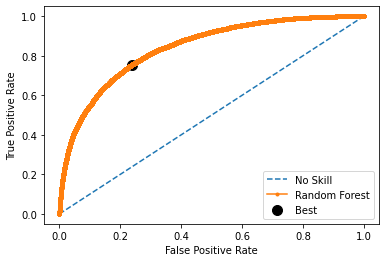

In [33]:
# keep probabilities for the positive outcome only
yhat = prob_predictions[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, yhat)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))

# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))


# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Random Forest')
plt.scatter(fpr[ix], tpr[ix], s=100, marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [34]:
CV.best_estimator_.named_steps['classifier'].feature_importances_

array([0.03882183, 0.00493515, 0.02490353, 0.01438609, 0.00881143,
       0.00492893, 0.0060592 , 0.00524339, 0.00439652, 0.01126837,
       0.        , 0.00801176, 0.00583246, 0.00435704, 0.        ,
       0.0078992 , 0.        , 0.00462295, 0.00767044, 0.00335466,
       0.        , 0.00183131, 0.01139002, 0.01398207, 0.        ,
       0.06771532, 0.00869431, 0.01907496, 0.03785041, 0.00595635,
       0.05958612, 0.1524732 , 0.01598467, 0.11975843, 0.0506534 ,
       0.0103112 , 0.01344229, 0.028743  , 0.06487411, 0.07409478,
       0.07808107], dtype=float32)

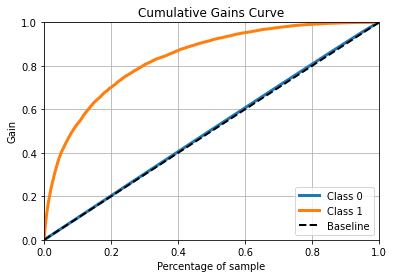

In [35]:
skplt.metrics.plot_cumulative_gain(y_test, prob_predictions)
plt.show()

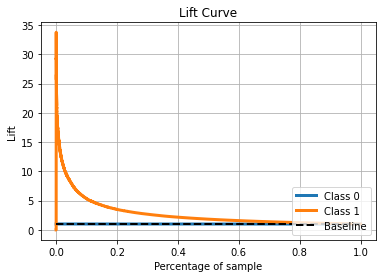

In [36]:
skplt.metrics.plot_lift_curve(y_test, prob_predictions)
plt.show()